In [20]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import cv2
from cv2 import aruco
from tqdm import tqdm
import msgpack as mp
import msgpack_numpy as mpn
from datetime import datetime

## Path definition

In [21]:
_pth = os.path.dirname(os.path.dirname(os.getcwd()))
_parent_folder = "data"
_calib_folder_name = "calib_mono_chessboard_corners"

_webcam_calib_folder = os.path.join(
    _pth, _parent_folder, "calibration", _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "test.msgpack")

In [22]:
chessb_corners = mp.Unpacker(open(_webcam_calib_video, "rb"), object_hook=mpn.decode)
chessb_corners = list(chessb_corners)

In [23]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 30
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)
worldPoints = []
imagePoints = []

In [24]:
def undistortFisheye(imgpath, K, D, DIM, axis, method, scale, corners):
    img = cv2.imread(imgpath)
    """
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, DIM, np.eye(3), balance=0)
    new_K = K.copy()
    new_K[0,0]=K[0,0]*scale
    new_K[1,1]=K[1,1]*scale
    """
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K, D, np.eye(3), K, DIM, cv2.CV_16SC2
    )
    undistorted_img = cv2.remap(
        img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT
    )

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    undCorners_norm = cv2.fisheye.undistortPoints(corners, K, D)
    undCorners_norm = undCorners_norm.reshape(-1, 2)
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x * fx + cx
        py = y * fy + cy
        undistCorners[i, 0] = px
        undistCorners[i, 1] = py
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)

    axs[axis].imshow(undistorted_img[:, :, ::-1])
    axs[axis].axis("off")
    axs[axis].set_title("undistort " + method)
    # cv2.imwrite('undistort'+method+'.png', undistorted_img)

    return corners, undistCorners


def undistortPinhole(imgpath, K, D, DIM, axis, method, corners):
    img = cv2.imread(imgpath)

    new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, DIM, 1, DIM)
    undistorted_img = cv2.undistort(img, K, D, None, new_K)

    undCorners_norm = cv2.undistortPoints(corners, K, D).reshape(-1, 2)
    # remove normalization
    fx = new_K[0, 0]
    fy = new_K[1, 1]
    cx = new_K[0, 2]
    cy = new_K[1, 2]
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x * fx + cx
        py = y * fy + cy
        undistCorners[i, 0] = px
        undistCorners[i, 1] = py
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)
    axs[axis].imshow(undistorted_img[:, :, ::-1])
    axs[axis].axis("off")
    axs[axis].set_title("undistorted " + method)

In [25]:
counter = 0
for _f in tqdm(chessb_corners):
    imagePoints.append(_f)
    worldPoints.append(boardPoints)
    counter += 1
    """cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
    plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(img[:,:,::-1])
    plt.axis('off')
    plt.title(fname)"""

100%|██████████| 630/630 [00:00<?, ?it/s]


In [26]:
if useFisheye:
    flagsCalib = (
        cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
        + cv2.fisheye.CALIB_FIX_SKEW
        + cv2.fisheye.CALIB_CHECK_COND
    )
    calibrateCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-12)
    ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
        np.expand_dims(np.asarray(worldPoints), -2),
        imagePoints,
        imgSize,
        None,
        None,
        flags=flagsCalib,
        criteria=calibrateCriteria,
    )
else:
    flagsCalib = cv2.CALIB_RATIONAL_MODEL
    ret, cameraMatrix, k, rvecs, tvecs = cv2.calibrateCamera(
        worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
    )

# print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

RMS re-projection error: 0.3066900919234907
Camera Matrix:
 [[759.78583311   0.         635.30360758]
 [  0.         762.81439633 399.14023285]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-0.0207248 ]
 [ 0.00181033]
 [-0.05370174]
 [ 0.03760771]]


In [27]:
ret

0.3066900919234907

In [28]:
_residual = []

for idx in range(len(t)):
    imgpoints, _ = cv2.fisheye.projectPoints(
        objectPoints=boardPoints.reshape(-1, 1, 3),
        rvec=R[idx].reshape(-1, 3),
        tvec=t[idx].reshape(-1, 3),
        K=cameraMatrix,
        D=k,
    )
    imgpoints = np.array(imgpoints).reshape(-1, 2).astype(float)

    corners = np.array(chessb_corners)[idx]
    corners = corners.reshape(-1, 2)
    _residual.append(corners - imgpoints)

sh = np.array(_residual).shape
_residual = np.array(_residual).reshape(sh[0] * sh[1], sh[2])

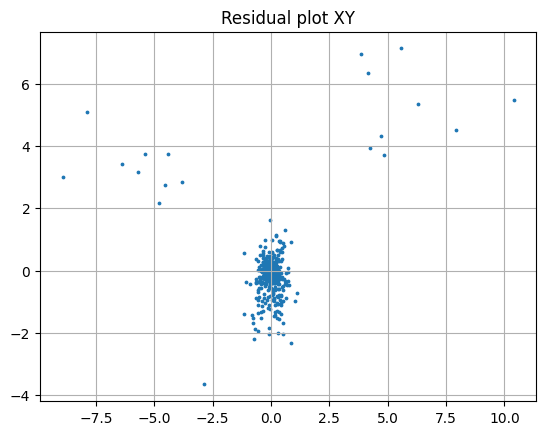

In [29]:
plt.scatter(_residual[:, 0], _residual[:, 1], s=3)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.title("Residual plot XY")
plt.grid("on")

In [30]:
len(worldPoints)

630

In [31]:
_april_raw_pth = r"E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings\mono_raw_t0\webcam_color.msgpack"

In [32]:
_object_file = mp.Unpacker(open(_april_raw_pth, "rb"), object_hook=mpn.decode)
_img_frame = next(_object_file)

(-0.5, 1279.5, 799.5, -0.5)

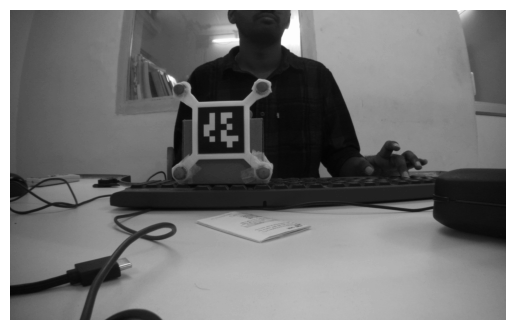

In [33]:
plt.imshow(_img_frame, cmap="grey")
plt.axis("off")

(-0.5, 1279.5, 799.5, -0.5)

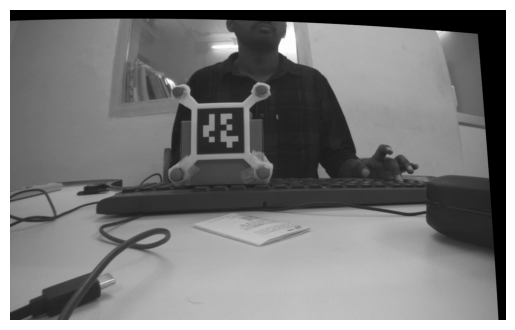

In [34]:
plt.imshow(cv2.undistort(_img_frame, cameraMatrix, k), cmap="grey")
plt.axis("off")

In [35]:
import toml

calib_file = toml.load(r"E:\CMC\pyprojects\programs_rpi\rpi_python\undistort_best.toml")

(-0.5, 1279.5, 799.5, -0.5)

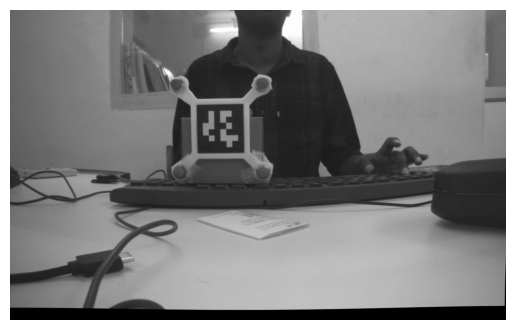

In [36]:
_mat = np.array(calib_file["calibration"]["camera_matrix"]).reshape(3, 3)
_dist = np.array(calib_file["calibration"]["dist_coeffs"])

plt.imshow(cv2.undistort(_img_frame, _mat, _dist), cmap="grey")
plt.axis("off")

In [2]:
import numpy as np


class Config:
    FRAME_SIZE = (1200, 800)
    MARKER_LENGTH = 0.05
    MARKER_SEPARATION = 0.01
    UDP_IP = "localhost"
    UDP_PORT = 8000
    DEFAULT_IDS = [4, 8, 12, 14, 20]
    ALPHA = 0.4  # Exponential moving average filter smoothing factor
    MARKER_OFFSETS = {
        4: np.array([-0.054, 0.031, -0.069]),
        8: np.array([0.00, 0.1025, -0.069]),
        12: np.array([0.00, 0.01, -0.069]),
        14: np.array([0.00, 0.031, -0.1075]),
        20: np.array([0.054, 0.031, -0.069]),
    }